In [19]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [20]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [21]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# Normalization
dataset = (dataset-data_mean)/data_std

In [22]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size,
                     target_size, step, single_step=False):
    data = []
    labels = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [24]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                TRAIN_SPLIT, past_history,
                                                future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                            TRAIN_SPLIT, None, past_history,
                                            future_target, STEP)

In [25]:
print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\nTarget Temperature to predict: {}'.format(y_train_multi[0].shape))

Single window of past history: (120, 3)

Target Temperature to predict: (72,)


In [26]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [27]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(
    32,
    return_sequences=True,
    input_shape=x_train_multi.shape[-2:]
))
multi_step_model.add(tf.keras.layers.LSTM(
    16,
    activation='relu'
))
multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                        loss="mae")

In [28]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [29]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                         steps_per_epoch=EVALUATION_INTERVAL,
                                         validation_data=val_data_multi,
                                         validation_steps=50)

Epoch 1/10
200/200 [==============================] - 16s 72ms/step - loss: 0.5349 - val_loss: 0.2991
Epoch 2/10
200/200 [==============================] - 14s 68ms/step - loss: 0.3323 - val_loss: 0.2674
Epoch 3/10
200/200 [==============================] - 14s 69ms/step - loss: 0.3058 - val_loss: 0.2517
Epoch 4/10
200/200 [==============================] - 14s 72ms/step - loss: 0.2514 - val_loss: 0.2289
Epoch 5/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2047 - val_loss: 0.1974
Epoch 6/10
200/200 [==============================] - 15s 73ms/step - loss: 0.2114 - val_loss: 0.2129
Epoch 7/10
200/200 [==============================] - 15s 73ms/step - loss: 0.2037 - val_loss: 0.2028
Epoch 8/10
200/200 [==============================] - 15s 73ms/step - loss: 0.1992 - val_loss: 0.2006
Epoch 9/10
200/200 [==============================] - 15s 76ms/step - loss: 0.2019 - val_loss: 0.2056
Epoch 10/10
200/200 [==============================] - 15s 75ms/step - loss: 0.190

In [32]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label="History")
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
            label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

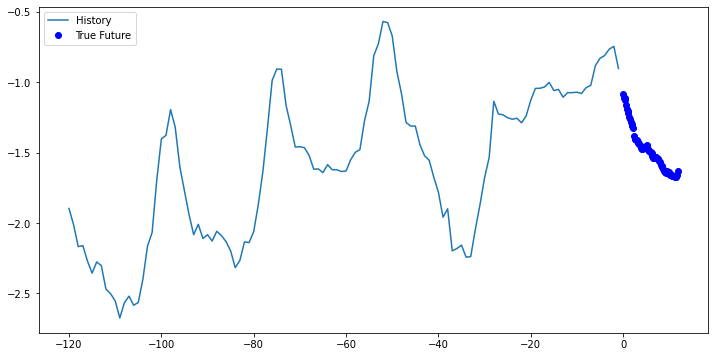

In [33]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [35]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

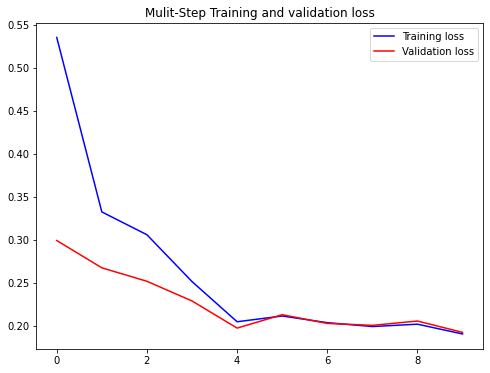

In [36]:
plot_train_history(multi_step_history, 'Mulit-Step Training and validation loss')

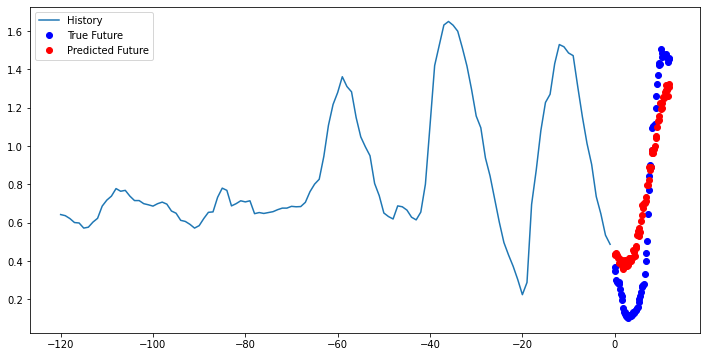

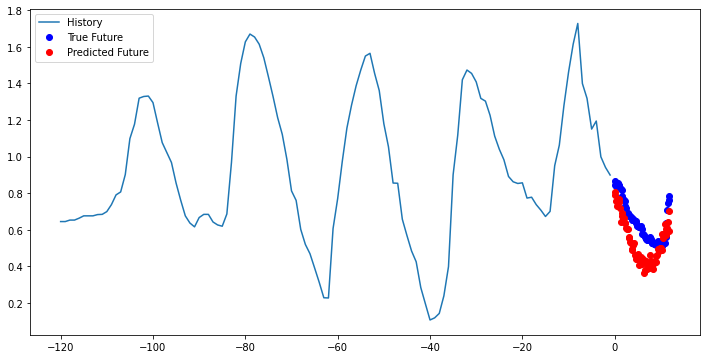

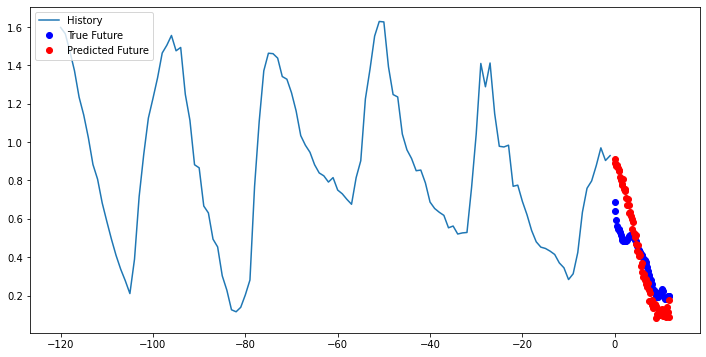

In [37]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])